# AIML Assignment 2: Unsupervised Learning
## Background: The Decline of Retail Malls

In August 2021, it was reported that retail sales in Singapore had risen by 25.8% on a year on year basis from 2020. [Source: CNA](https://www.channelnewsasia.com/singapore/retail-sales-index-food-beverage-june-2021-2094341)

However, this was due to the shut down of physical stores as a result of the COVID-19 pandemic. Hence, this percentage rise was calculated on a low base, and hides a trend that has been occuring even before COVID-19, which is the decline in physical retail shopping. 

According to the Singapore Department of Statistics (SingStat), The average retail sales per square meter has fallen by around $400/m2 from 2009 to 2019, mostly due to a decline in general merchandise sales, where retail sales per square meter has fallen by more than $2000/m2. [Source: Department of Statistics, Singapore](https://www.singstat.gov.sg/modules/infographics/retail)

In contrast to the decline in physical retail, SingStat reports that 2021 saw an increase in online retail sales.

Thus, mall operators around Singapore face a growing threat. Their business model is based mostly around leasing space to retail shops, and earning money off the rent. If physical retail becomes less popular, there will be a decline in shops, and thus rental fees, reducing their revenue stream.

## Problem Statement

One way for malls to maintain their revenue streams is to better understand their customers, so as to determine a core customer case, for which a marketing strategy can be devised to retain their loyalty. 

Hence, our objective is to applying clustering techniques to segment our customers, and identify a customer segment to target.



## Library Imports

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Statistical Analysis
from scipy import stats

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Pipelines
from sklearn.pipeline import Pipeline
# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering ,DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram


# Hyperparameter Tuning
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import make_scorer
sns.set()

## Data Ingestion

In [3]:
df = pd.read_csv("Mall_Customers.csv", index_col=0)
df.head()

Genre  Age  Annual Income (k$)  Spending Score (1-100)
CustomerID                                                         
1             Male   19                  15                      39
2             Male   21                  15                      81
3           Female   20                  16                       6
4           Female   23                  16                      77
5           Female   31                  17                      40

## Exploratory Data Analysis

Before embarking on our customer segmentation task, we will take some time to explore the data, to gain a better understanding of our customer base.

### Dataset Features


| Features | Data Type | Description |
|---|---|---|
|Gender | Categorical | Either Male or Female |
| Age | Numerical (Discrete) | How old the customer is. |
| Annual Income (k$) | Numerical (Continuous) | Annual income in thousands (assume USD) |
| Spending Score (1-100) | Categorical (Ordinal) | Spending behaviour, a high spending score might indicate a customer who spends more money in the mall |


### Questions
- How many observations are there in the data?
- Are there any errors or missing values in the data?
- What does the distribution of the features look like?
- Is there any relationship between the variables in the data?
- How important is gender in affecting the distribution of the data?

In [4]:
df_eda = df.copy(deep=True)

### How many observations are there in the data?

In [5]:
rows, cols = df_eda.shape
print("There are {} rows and {} columns in the data.".format(rows, cols))

There are 200 rows and 4 columns in the data.


### Are there any errors or missing values in the data?

In [7]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Genre                   200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


On first glance,
- it appears there are no missing values in the data
- the "Gender" column is mispelled as "Genre"
- the data types for each attribute are correct

We will fix the misnamed column by renaming it to the proper name.

In [8]:
df.rename(columns={"Genre" : "Gender"}, inplace=True)
df_eda.rename(columns={"Genre" : "Gender"}, inplace=True)

In [9]:
df_eda.describe()

Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     49.000000           78.000000               73.000000
max     70.000000          137.000000               99.000000

From looking at the descriptive statistics, nothing stands out as being particularly anomalous.

### Data Distributions

In [10]:
df_eda.describe()

Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     49.000000           78.000000               73.000000
max     70.000000          137.000000               99.000000

- The mean age of 38.85 (approximately 39) is higher than the median age of 36, suggesting the distribution of age is positively skewed
- The typical customer of the mall is middle aged, as approximately 50% of all customers are between 28 and 49 years old
- The mean annual income is similar to the median annual income, suggesting the distribution is not significantly skewed.
- The mean spending is similar to the median spending score, suggesting that the distribution is not significantly skewed.

<ipython-input-28-67d4f98dea7c>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


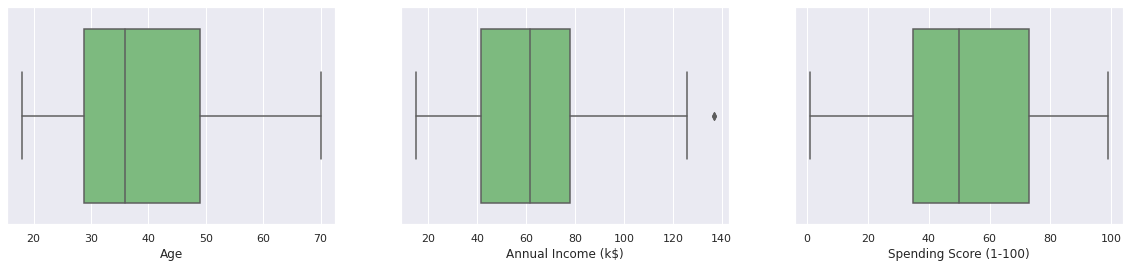

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for ax, col in zip(axes, df_eda.drop('Gender', axis=1).columns):
    sns.boxplot(data=df_eda, x=col, ax = ax, palette="Greens")
fig.show()

#### Age
- As initially discovered from the descriptive statistics, we see that the age distribution is positively skewed, and that most customers are middle aged.

#### Annual Income
- We see that the majority of customers earn between $3000 to $7000 per month. 
- This is consistent with the average incomes of Singaporeans, which stands at around $5.7K per month ($68.4k annually)
- This suggest that most of our customers have a middle class background, as such wages would be typical of white collar jobs.
- We could potentially increase the spending power of our average customers by offering a buy now, pay later scheme, where they pay in interest free installments.
- There are a minority of customers that earn in excess of $90k per year, meaning that they have significant spending power.
- We observe that we have a single outlier, who earns close to $140,000 annually (or close to $11k per month)

#### Spending Score

- Most shoppers have spending scores between 35 and 70
- There are no customers with outlier spending scores.
- The distribution of spending scores is slightly positively skewed.

<AxesSubplot:>

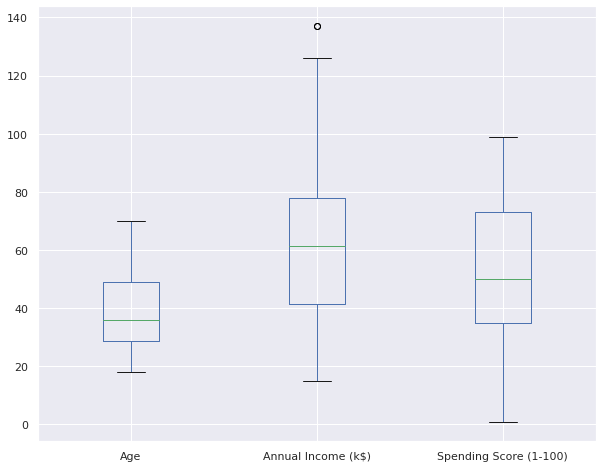

In [46]:
df_eda.plot(kind='box', figsize=(10, 8))

- From analysing the box plots, we note that Annual Income and Spending score have similar interquartile ranges
- Age has a slightly smaller interquartile range

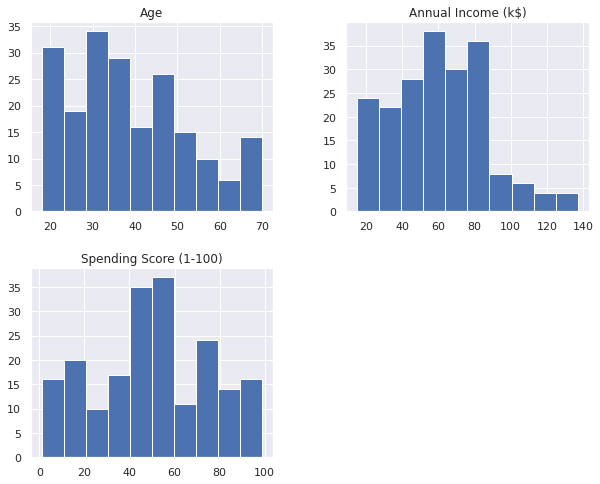

In [49]:
df_eda.hist(figsize=(10, 8))
plt.show()

### Is there any relationship between the variables in the data?

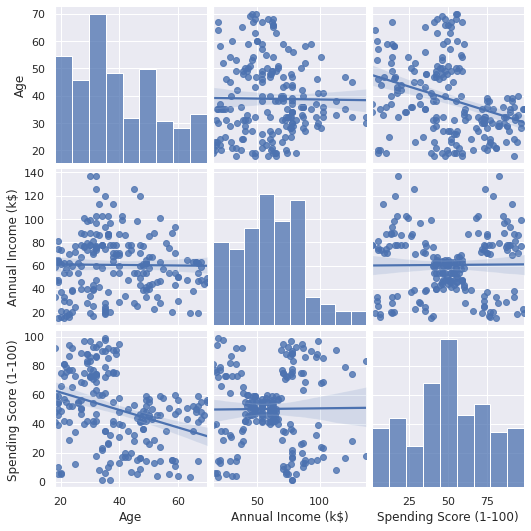

In [34]:
sns.pairplot(df_eda, kind='reg')

- Between Age and Annual Income, there does not appear to be any significant relationship
- It appears that younger people tend to have a higher spending score. This could be because older people have less need to purchase items
- Annual Income and Spending Score appears to form 5 natural clusters

<AxesSubplot:>

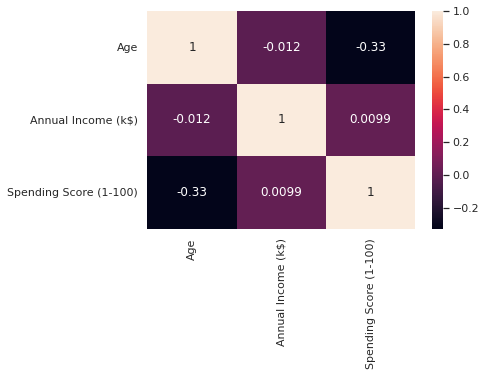

In [35]:
sns.heatmap(df_eda.corr(), annot=True)

- The correlation heatmap appears to support our observations that there is a negative weak linear relationship between age and spending score

### How important is gender in affecting the distribution of the data?

Our dataset contains the Gender feature. In theory, customers of different genders may have different spending habits. For example, we might expect female customers to spend more money on cosmetics products, which are mainly targeted at females. This suggests that the feature may be useful.

However, the gender feature poses a few problems for our customer segmentation:
- Gender is a categorical variable. Even if encoded into a binary 1 and 0, certain clustering techniques (e.g. KMeans with Eucluidian distances) may not make sense, as the euclidian distance between Males and Females makes not sense at all. The resulting cluster center coordinate for Gender would also not make sense as well. This could be solved by using other clustering methods (e.g. K-Prototypes).
- We already have three other features. Hence, visualising the clustering would require us to visualise 4 dimensions (gender, age, spending, income, and the cluster labels). This means that we would have to drop one of other features if we want to use the Gender feature.

Hence, we want to determine if there is a significant difference between the demographics and habits of both genders. This may help us decide on a future course of action for what to do with the feature. 

<ipython-input-40-38867f82b1fa>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


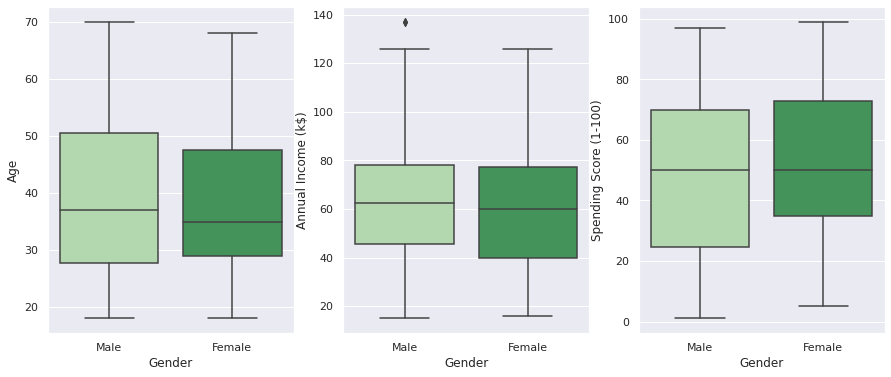

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
for ax, col in zip(axes, df_eda.drop('Gender', axis=1).columns):
    sns.boxplot(data=df_eda, y=col, x='Gender', ax = ax, palette="Greens")
fig.show()

From comparing the distributions when grouped by age, it appears there is no significant difference between the distributions of males and females

To further test our hypothesis, we will perform a statistical two sample t-test on the means of both genders. 

In [36]:
df.pivot(columns='Gender')['Age']

Gender      Female  Male
CustomerID              
1              NaN  19.0
2              NaN  21.0
3             20.0   NaN
4             23.0   NaN
5             31.0   NaN
...            ...   ...
196           35.0   NaN
197           45.0   NaN
198            NaN  32.0
199            NaN  32.0
200            NaN  30.0

[200 rows x 2 columns]

In [41]:
def two_sample_t_test(data, col, level = 'Gender', equal_variances = True, significance_level = 0.05):
    pivoted_data = data.pivot(columns=level)[col]
    a, b = pivoted_data.iloc[:, 0].dropna(), pivoted_data.iloc[:, 1].dropna()
    text = f"Two Sample T-Test (assume {'' if equal_variances else 'no'} equal variances)\nH0 : Population means are equal\nH1 : Population means are not equal\nSignificance Level = {significance_level}"
    print(text)
    t_score, pvalue = stats.ttest_ind(a, b, equal_var=equal_variances)
    print("The p-value is", pvalue)
    if pvalue > significance_level:
        print("There is insufficient evidence to reject the null hypothesis that the population means are equal.")
    else:
        print("There is evidence to reject the null hypothesis that the population means are equal.")

In [42]:
df.groupby('Gender').var()

Age  Annual Income (k$)  Spending Score (1-100)
Gender                                                        
Female  159.873150          676.621622              581.530808
Male    240.709378          709.602926              778.229754

We observe that the sample variances of both samples are similar, hence we will assume equal variances.

In [43]:
for col in ('Age', 'Annual Income (k$)', 'Spending Score (1-100)'):
    print(col)
    two_sample_t_test(df, col)
    print()

Age
Two Sample T-Test (assume  equal variances)
H0 : Population means are equal
H1 : Population means are not equal
Significance Level = 0.05
The p-value is 0.3918907377882569
There is insufficient evidence to reject the null hypothesis that the population means are equal.

Annual Income (k$)
Two Sample T-Test (assume  equal variances)
H0 : Population means are equal
H1 : Population means are not equal
Significance Level = 0.05
The p-value is 0.42755249399927864
There is insufficient evidence to reject the null hypothesis that the population means are equal.

Spending Score (1-100)
Two Sample T-Test (assume  equal variances)
H0 : Population means are equal
H1 : Population means are not equal
Significance Level = 0.05
The p-value is 0.4137446589852176
There is insufficient evidence to reject the null hypothesis that the population means are equal.



From the t-test, it appears that Gender does not have a significant impact on the distribution of data.

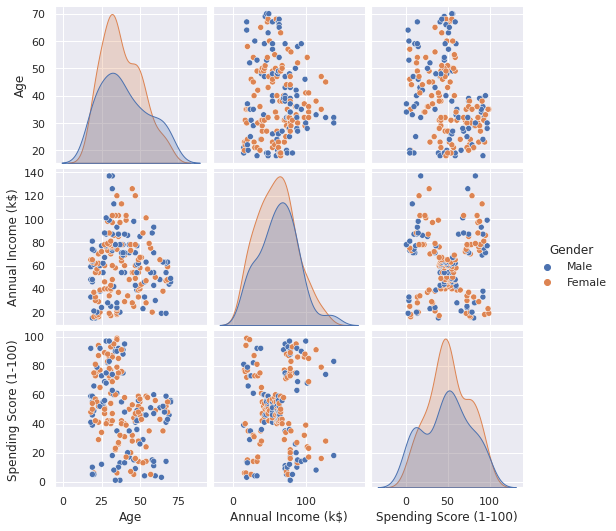

In [44]:
sns.pairplot(df_eda, hue="Gender")

We analysing the scatter plots when colored by gender, we see that the samples are not distinguishable.

## Data Preprocessing

Now, we will prepare our data for the clustering task.

To process our data, we will simply choose to drop the Gender variable. No scaling will be done on our data as our data are on a similar scale.

In [50]:
data = df.drop('Gender', axis=1)

## Clustering

### K-Means Clustering

#### Using a Scree Plot to Select Initial Number of Clusters

In [55]:
def scree_plot(algo, n_clusters_max = 12, n_clusters_min = 2, figsize=(10, 8), model_params={}):
    n = list(range(n_clusters_min, n_clusters_max + 1))
    fig, ax = plt.subplots(figsize=figsize)
    inertia = []
    cluster_per_n = []
    for no_cluster in n:
        model = algo(n_clusters=no_cluster, *model_params)
        clusters = model.fit_predict(data)
        cluster_per_n.append(clusters)
        inertia.append(model.inertia_)
    ax.plot(n, inertia, 'o-')  
    ax.set_title("Scree Plot")
    ax.set_ylabel('Inertia')
    ax.set_xlabel('No of Clusters')
    return fig

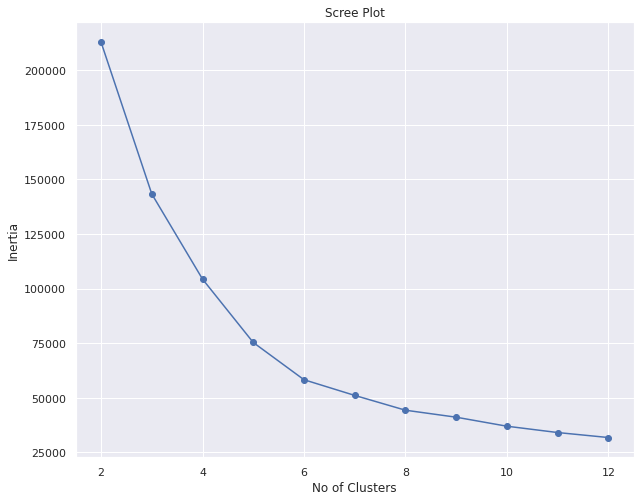

In [56]:
fig = scree_plot(KMeans)

Based off the scree plot, the elbow appears to be between 5 to 7 clusters. A good choice for the number of clusters appears to be 6 clusters.

#### Clustering Result

In [68]:
kmeans_df = data.copy()
model = KMeans(6)
cluster_labels = model.fit_predict(data)
kmeans_df['cluster'] = cluster_labels

In [83]:
cluster_centers = pd.DataFrame(model.cluster_centers_, columns=df.drop('Gender', axis=1).columns)
cluster_centers['Cluster Size (% of Total)'] = pd.Series(cluster_labels).value_counts() / len(cluster_labels) * 100
cluster_centers

Age  Annual Income (k$)  Spending Score (1-100)  \
0  41.685714           88.228571               17.285714   
1  25.272727           25.727273               79.363636   
2  27.000000           56.657895               49.131579   
3  32.692308           86.538462               82.128205   
4  56.155556           53.377778               49.088889   
5  44.142857           25.142857               19.523810   

   Cluster Size (% of Total)  
0                       17.5  
1                       11.0  
2                       19.0  
3                       19.5  
4                       22.5  
5                       10.5

In [81]:
fig = px.scatter_3d(data_frame=data, color=cluster_labels, x='Age', y='Annual Income (k$)', z='Spending Score (1-100)')
fig.add_trace(go.Scatter3d(x=cluster_centers['Age'], y=cluster_centers['Annual Income (k$)'], z=cluster_centers['Spending Score (1-100)'], mode='markers', marker=dict(symbol='diamond', color='green')))

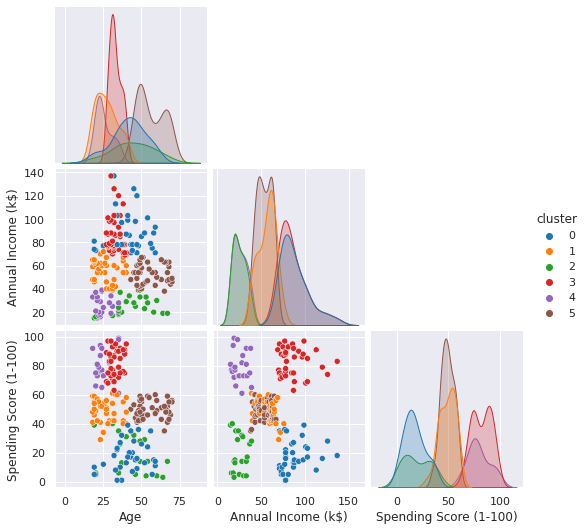

In [67]:
sns.pairplot(kmeans_df, hue='cluster', corner=True, palette="tab10")

In [84]:
cluster_centers

Age  Annual Income (k$)  Spending Score (1-100)  \
0  41.685714           88.228571               17.285714   
1  25.272727           25.727273               79.363636   
2  27.000000           56.657895               49.131579   
3  32.692308           86.538462               82.128205   
4  56.155556           53.377778               49.088889   
5  44.142857           25.142857               19.523810   

   Cluster Size (% of Total)  
0                       17.5  
1                       11.0  
2                       19.0  
3                       19.5  
4                       22.5  
5                       10.5

#### Interpretation
| Cluster Number | Age | Annual Income | Spending Score | Cluster Size |
|---|---|---|---|---|
|0|Middle Age|High Income|Low Spending|Medium|
|1|Young Age | Low Income | Low Income | High Spending | Small |
|2|Young-Middle Age| Medium Income | Medium Spending | Large |
|3|Middle Age | High Income | High Spending | Large |
|4|Old Age | Middle Income | Medium Spending | Large |
|5|Old Age | Low Income | Low Spending | Small |


### Hierarchical Clustering

#### Using a Dendrogram to Select Initial Number of Clusters

In [85]:
h_clust = AgglomerativeClustering(compute_distances=True, compute_full_tree=True)
h_clust.fit(data)

AgglomerativeClustering(compute_distances=True, compute_full_tree=True)

In [86]:
counts = np.zeros(h_clust.children_.shape[0])
n_samples = len(h_clust.labels_)
for i, merge in enumerate(h_clust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count
linkage = np.column_stack([h_clust.children_, h_clust.distances_, counts]).astype(float)

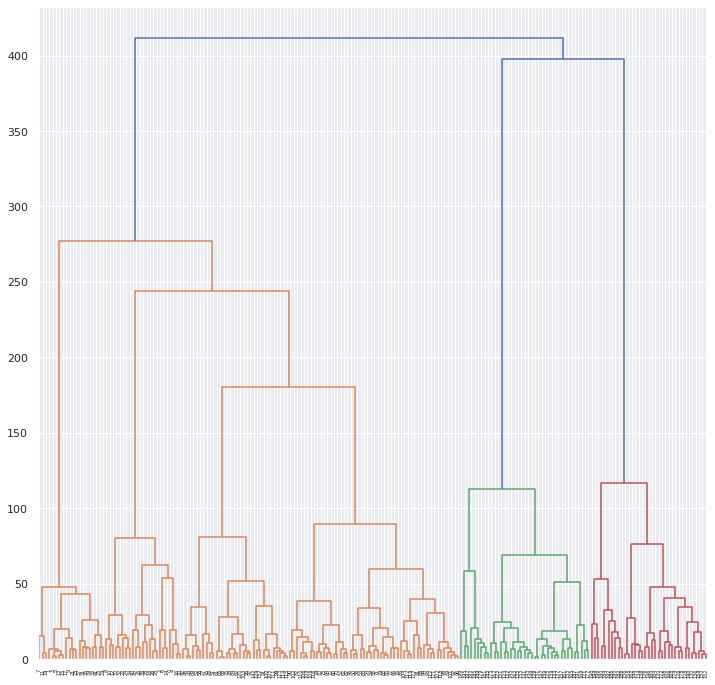

In [87]:
fig, ax = plt.subplots(figsize=(12, 12))
dendrogram(linkage)
plt.show()

Based off the dendrogram, it would be good to either cut off the dendrogram at 6 clusters, or at 8 clusters (so, between 6 to 8)

For this clustering, we will attempt

#### Clustering Result

#### Default Parameters

In [92]:
h_clust_df = data.copy()
h_clust = AgglomerativeClustering()
cluster_labels = h_clust.fit_predict(data)
h_clust_df['cluster'] = cluster_labels

In [95]:
px.scatter_3d(data_frame=h_clust_df, color='cluster', x='Age', y='Annual Income (k$)', z='Spending Score (1-100)')

In [68]:
kmeans_df = data.copy()
model = KMeans(6)
cluster_labels = model.fit_predict(data)
kmeans_df['cluster'] = cluster_labels

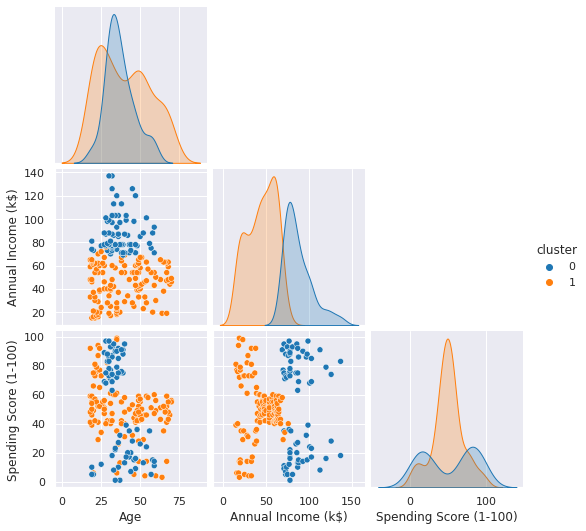

In [96]:
sns.pairplot(h_clust_df, hue='cluster', corner=True, palette="tab10")

#### 6 Clusters

In [97]:
h_clust_df = data.copy()
h_clust = AgglomerativeClustering(n_clusters=6)
cluster_labels = h_clust.fit_predict(data)
h_clust_df['cluster'] = cluster_labels

In [98]:
px.scatter_3d(data_frame=h_clust_df, color='cluster', x='Age', y='Annual Income (k$)', z='Spending Score (1-100)')

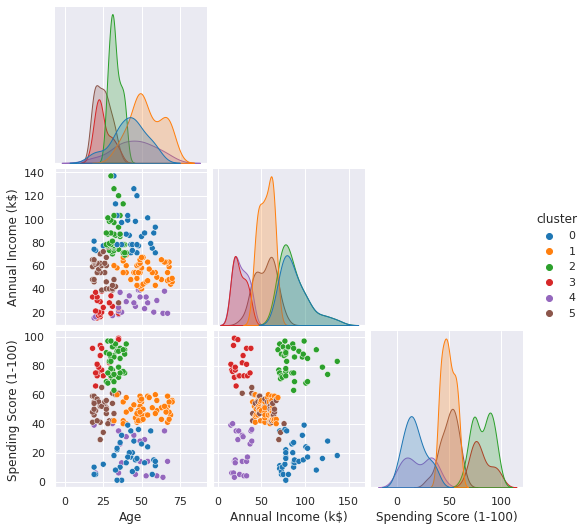

In [99]:
sns.pairplot(h_clust_df, hue='cluster', corner=True, palette="tab10")

### Gaussian Mixture Model

#### Determining the Number of Components via the BIC

In [102]:
bic = []

for n_components in range(1, 9):
    model = GaussianMixture(n_components=n_components)
    model.fit(data)
    bic.append(model.bic(data))

best_n_components = np.argmin(bic) + 1
print("Best number of components:", best_n_components)

Best number of components: 5


Text(0.5, 1.0, 'No of Components vs BIC')

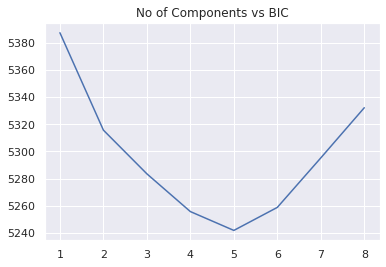

In [182]:
pd.Series(bic, index=range(1, 9)).plot()
plt.title("No of Components vs BIC")
plt.xlabel("No of Components")
plt.ylabel("BIC")

#### Clustering Result

In [103]:
gmm_df = data.copy()

cluster_labels = GaussianMixture(n_components=5).fit_predict(gmm_df)

gmm_df['cluster'] = cluster_labels

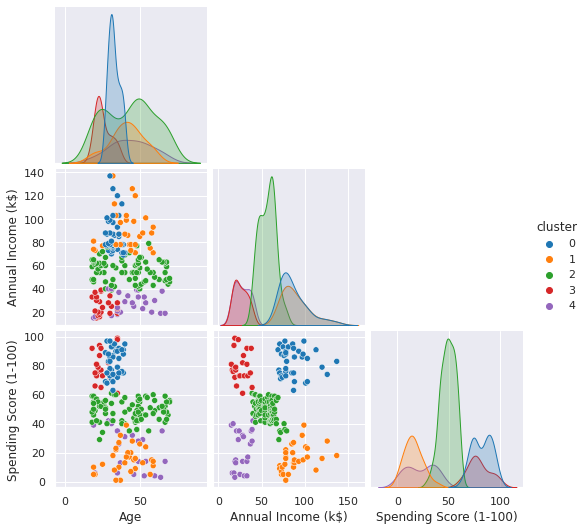

In [104]:
sns.pairplot(gmm_df, hue='cluster', corner=True, palette="tab10")

In [105]:
px.scatter_3d(data_frame=gmm_df, color='cluster', x='Age', y='Annual Income (k$)', z='Spending Score (1-100)')

### DBSCAN

#### Clustering Result

In [109]:
dbscan_df = data.copy()

model = DBSCAN()
cluster_labels = model.fit(dbscan_df)
dbscan_df['cluster'] = cluster_labels

In [110]:
px.scatter_3d(data_frame=dbscan_df, color='cluster', x='Age', y='Annual Income (k$)', z='Spending Score (1-100)')

## Model Improvement

### Silhouette Analysis to Determine the Optimal Number of Clusters

In [111]:
# Credit, code modified from: https://chart-studio.plotly.com/~Diksha_Gabha/2853.embed#:~:text=The%20silhouette%20plot%20displays%20a,of%20%5B%2D1%2C%201%5D.
def plot_silhouette(cluster_labels, data, n_clusters):
    avg_silhouette = silhouette_score(data, cluster_labels) # avg_silhouette gives us a measure of overall clustering quality
    print(f"Average Silhouette Score for {n_clusters} clusters: {avg_silhouette}")
    sample_silhouette_values = silhouette_samples(data, cluster_labels) # calculate silhouette scores for individual samples
    fig = make_subplots(rows=1, cols=2, print_grid=False, subplot_titles=('Silhouette Scores (by Clusters) Plot', 'Scatterplot of Clustering'), specs=[[{'type':'xy'}, {'type':'scene'}]])
    fig['layout']['xaxis1'].update(title='Silhouette Coefficient')
    fig['layout']['yaxis1'].update(title='Cluster Label', showticklabels=False, range=[0, len(data) + (n_clusters + 1) * 10])
    fig.update_scenes(dict(
        xaxis_title = 'Age',
        yaxis_title = 'Annual Income (k$)',
        zaxis_title = 'Spending Score (1-100)'
    ))
    y_lower = 10
    for i in range(n_clusters):
        cluster_silhouettes = sample_silhouette_values[cluster_labels == i]
        cluster_silhouettes.sort()
        cluster_size = cluster_silhouettes.shape[0]
        y_upper = y_lower + cluster_size
        #colors = cm.get_cmap("Spectral")
        colors = sns.color_palette('tab10')
        c = f'rgb({colors[i][0] * 255}, {colors[i][1] * 255}, {colors[i][2] * 255})'
        filled_area = go.Scatter(y=np.arange(y_lower, y_upper), x=cluster_silhouettes, mode='lines', showlegend=False, line=dict(width=0.5, color=c), fill='tozerox')
        y_lower = y_upper + 10
        fig.append_trace(filled_area, 1, 1)
    avg_line = go.Scatter(x=[avg_silhouette] * 500, y=np.arange(500), showlegend=False, mode='lines', line=dict(color='red', dash='dash', width=1), fill='tozeroy')
    fig.append_trace(avg_line, 1, 1)
    cmap = dict(zip(np.sort(np.unique(cluster_labels)), colors))
    scatter = go.Scatter3d(x = data['Age'], y=data['Annual Income (k$)'], z=data['Spending Score (1-100)'], mode='markers', marker=dict(color=list(map(lambda x : tuple(np.array(cmap[x]) * 255), cluster_labels))))
    fig.append_trace(scatter, 1, 2)
        
    return fig, avg_silhouette

In [119]:
def test_clusters(model, data, n_range = range(2, 10)):
    try:
        figures, models = tuple(zip(*[plot_silhouette(labels, data, n_clusters) for labels, n_clusters in [
            (model(n_clusters=i).fit_predict(data), i) for i in n_range
        ]]))
    except:
        figures, models = tuple(zip(*[plot_silhouette(labels, data, n_clusters) for labels, n_clusters in [
            (model(n_components=i).fit_predict(data), i) for i in n_range
        ]]))
    return figures, models

#### K-Means

In [179]:
figs, models = test_clusters(KMeans, data)

Average Silhouette Score for 2 clusters: 0.293166070535953
Average Silhouette Score for 3 clusters: 0.3839349967742105
Average Silhouette Score for 4 clusters: 0.40546302077733304
Average Silhouette Score for 5 clusters: 0.44428597560893024
Average Silhouette Score for 6 clusters: 0.4523443947724053
Average Silhouette Score for 7 clusters: 0.4412807576186172
Average Silhouette Score for 8 clusters: 0.42790288922594905
Average Silhouette Score for 9 clusters: 0.3892924387897419


Looking at the average silhouette scores, a choice of 6 or 5 clusters appears to be the best.

##### 5 Clusters

In [121]:
figs[5-2]

- From the silhouette plot we observe that:
    - the cluster sizes are uneven, as some clusters (e.g green and red) are small, while the orange and purple clusters are larger
    - this time, most clusters have most of their points being above the average silhouette score (which is also 0.04 higher than with 4 clusters), meaning the clusters are more well defined
    - the red cluster is the most well defined, as it appears that all of the points there have a high silhouette score
    - the least well defined clusters are the orange cluster, where less than half of points inside it have an above average silhouette coefficient, with some points having negative silhouette scores

- Visually:
    - there is some overlap between the orange and red cluster
        - the orange cluster represents people of all ages who are middle income and have a moderate spending score
        - the red cluster represents young people who are low-middle income with moderate to high spending scores
        - thus, there is some overlap for young people who are just below middle income and have moderate spending scores, causing the orange cluster to not be as well defined.
    - there is also some overlap between the orange and purple cluster:
        - the orange cluster represents people of above average income who spend frugally
        - the overlap comes with people who are just above average, and who have a moderate spending score, which are very close to the orange cluster

##### 6 Clusters

In [180]:
figs[6-2]

- From inspecting the silhouette plot, we note:
    - The clusters are more evenly formed now, with clusters having similar sizes
    - There has been a marginal improvement in the average silhouette score, but not by much
    - The most well defined cluster appears to be the blue cluster, followed by the purple cluster
    - The least well defined clusters are the red, brown and orange clusters.
    - The brown cluster has two points which have a negative silhouette score (suggesting they are misclassified)

#### Hierarchical Clustering

In [151]:
figs, models = test_clusters(AgglomerativeClustering, data)

Average Silhouette Score for 2 clusters: 0.2992593203550994
Average Silhouette Score for 3 clusters: 0.38141795042544546
Average Silhouette Score for 4 clusters: 0.41037986351850747
Average Silhouette Score for 5 clusters: 0.4401889024290193
Average Silhouette Score for 6 clusters: 0.44308912983504156
Average Silhouette Score for 7 clusters: 0.4262301125101286
Average Silhouette Score for 8 clusters: 0.41028404899198817
Average Silhouette Score for 9 clusters: 0.3663955117052502


##### 5 Clusters

In [152]:
figs[5-2]

##### 6 Clusters

In [153]:
figs[6-2]

- The clusters formed appear to be less defined than those formed by KMeans, as we observe that out of all of the clusters, 4 of them contain points with negative silhouette scores, suggesting that they are in the wrong clusters. This suggests that the clusters formed are less defined than those of KMeans

### Hyperparameter Tuning GMM

In [146]:
param_grid = {
    "n_components" : range(2, 8),
    "covariance_type" : ('full', 'tied', 'diag', 'spherical')
}

In [166]:
scores = []
for params in ParameterGrid(param_grid):
    cluster_labels = GaussianMixture(**params).fit_predict(data)
    score = silhouette_score(data, cluster_labels)
    scores.append((score, params))

best_score, best_params = sorted(scores, key = lambda x : x[0], reverse=True)[0]
print("Best score:", best_score)
print("Best params:", best_params)

Best score: 0.4458378313266269
Best params: {'covariance_type': 'full', 'n_components': 6}


In [168]:
cluster_labels = GaussianMixture(**best_params).fit_predict(data)
fig, avg_silhouette = plot_silhouette(cluster_labels, data, 6)
fig

Average Silhouette Score for 6 clusters: 0.4458378313266269


- The clusters formed face a similar issue as hierarchical clustering, where 4 of the clusters formed do not appear to be as well defined as they could be.

## Final Clustering

In [176]:
final_df = data.copy()
final_model = KMeans(6).fit(data)

cluster_labels = final_model.predict(data)
cluster_centers = pd.DataFrame(final_model.cluster_centers_, columns=df.drop('Gender', axis=1).columns)
cluster_centers['Cluster Size (% of Total)'] = pd.Series(cluster_labels).value_counts() / len(cluster_labels) * 100
final_df['Cluster'] = cluster_labels

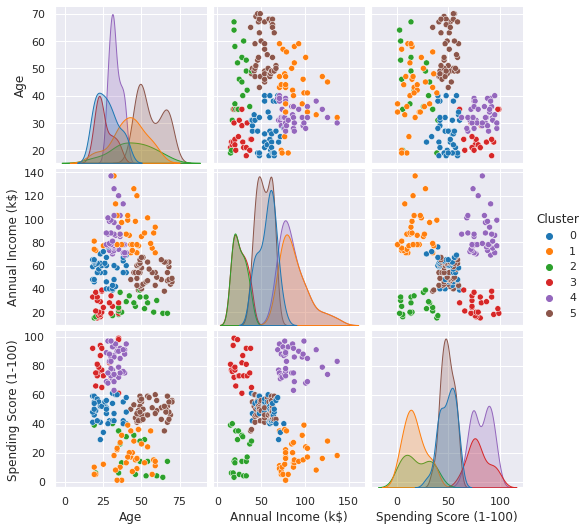

In [172]:
sns.pairplot(final_df, hue="Cluster", palette="tab10")

In [177]:
fig = px.scatter_3d(data_frame=final_df, x='Age', y='Annual Income (k$)', z='Spending Score (1-100)', color='Cluster')
fig.add_trace(go.Scatter3d(x=cluster_centers['Age'], y=cluster_centers['Annual Income (k$)'], z=cluster_centers['Spending Score (1-100)'], mode='markers', marker=dict(symbol='diamond', color='green')))

### Interpretation of Clusters

### Which Customer Segment is the Most Lucrative?

### Recommendations